# 实作DCGAN演算法，产生手写阿拉伯数字
### 程式修改自[DCGAN-MNIST-pytorch](https://github.com/Ksuryateja/DCGAN-MNIST-pytorch)

## 载入套件

In [19]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision import utils as vutils

## 设定参数

In [2]:
PATH_DATASETS = "" # 预设路径
BATCH_SIZE = 64  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 载入 MNIST 手写阿拉伯数字资料

In [32]:
# 转换
transform=transforms.Compose([
   transforms.Resize(28),
   transforms.ToTensor(),
   transforms.Normalize((0.5,), (0.5,)),
])

# 下载 MNIST 手写阿拉伯数字 训练资料
dataset = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transform)
dataloader = torch.utils.data.DataLoader(dataset
                   , batch_size=BATCH_SIZE, shuffle=True)

# 训练资料的维度
print(train_ds.data.shape)

torch.Size([60000, 28, 28])


## 定义神经网路参数

In [6]:
nz = 100  # 生成神经网路杂讯维度
ngf = 64  # 生成神经网路滤波器个数
ndf = 64  # 判别神经网路滤波器个数

## 神经网路权重初始值

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # 卷积层权重初始值 
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # Batch Normalization 层权重初始值 
        m.bias.data.fill_(0)

## 定义生成神经网路

In [9]:
class Generator(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, 
                               stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output
    
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

## 定义判别神经网路

In [11]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

## 设定损失函数、优化器(optimizer)

In [13]:
# 设定损失函数
criterion = nn.BCELoss()

# 设定优化器(optimizer)
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

## 进行模型训练

In [33]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0
niter = 25
# 模型训练
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ########################################################
        # (1) 判别神经网路: maximize log(D(x)) + log(1 - D(G(z)))
        #######################################################
        # 训练真实资料
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 训练假资料
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ########################################################
        # (2) 判别神经网路: maximize log(D(G(z)))
        #######################################################
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 200 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch+1, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            vutils.save_image(real_cpu,'gan_output/real_samples.png' ,normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'gan_output/fake_samples_epoch_%03d.png' 
                              % (epoch), normalize=True)        
    torch.save(netG.state_dict(), 'gan_weights/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'gan_weights/netD_epoch_%d.pth' % (epoch))

[1/25][0/938] Loss_D: 0.8940 Loss_G: 1.4861 D(x): 0.6093 D(G(z)): 0.2532 / 0.2736


KeyboardInterrupt: 

## 新资料预测

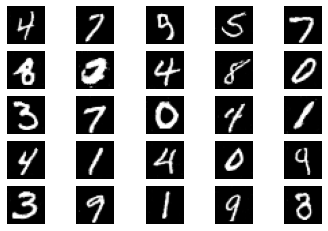

In [31]:
import matplotlib.pyplot as plt

batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = netG(fixed_noise)
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.axis('off')
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

## 显示 GIF 档

In [27]:
# 安装产生 GIF 档的套件
!pip install -q imageio

In [30]:
import imageio
import glob

# 产生 GIF 档
anim_file = './gan_output/dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./gan_output/fake_samples*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image) 

<img src="./gan_output/dcgan.gif" align="left">